<a href="https://colab.research.google.com/github/machiwao/ml-development/blob/main/tutorial_files/fccamp_SeoulBikeData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

#Dataset Reference
Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [41]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv('SeoulBikeData.csv', encoding = 'latin-1').drop(["Date", "Holiday", "Seasons"], axis = 1)

In [42]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)

In [43]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


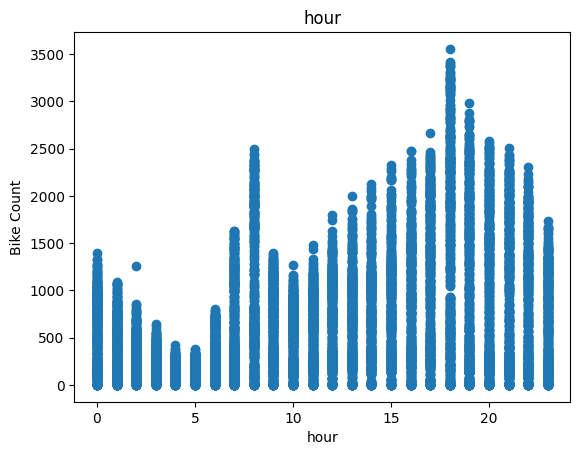

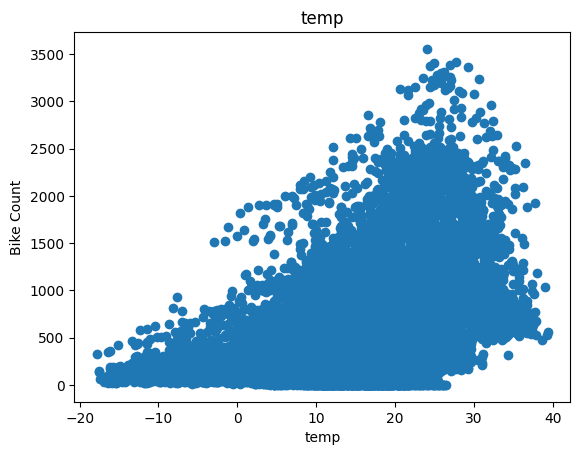

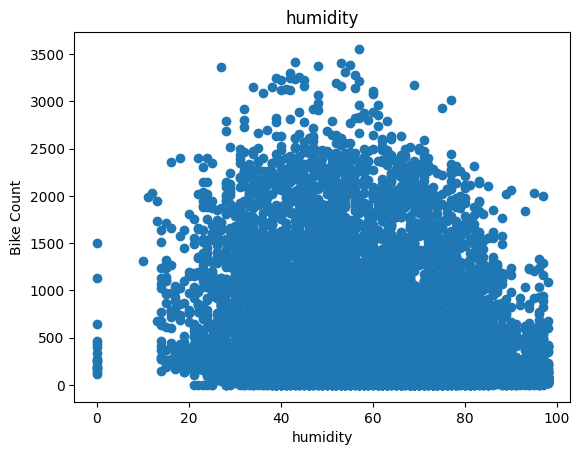

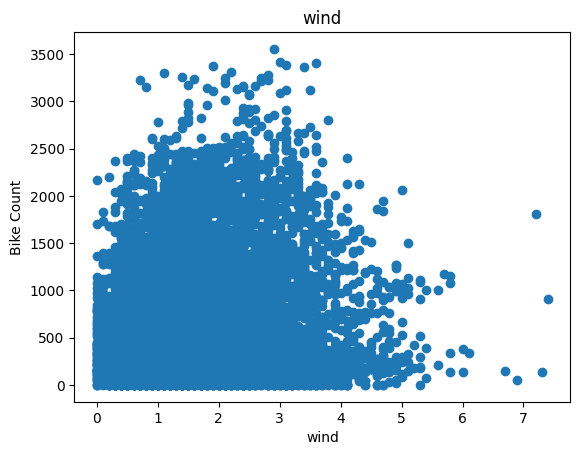

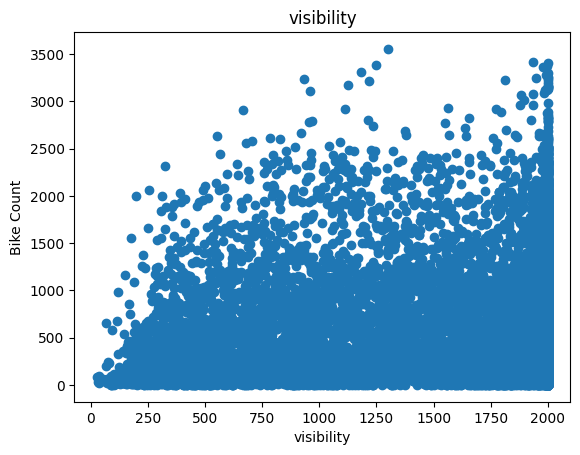

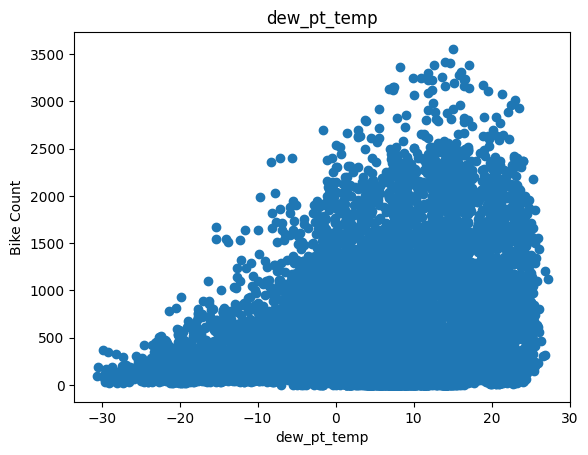

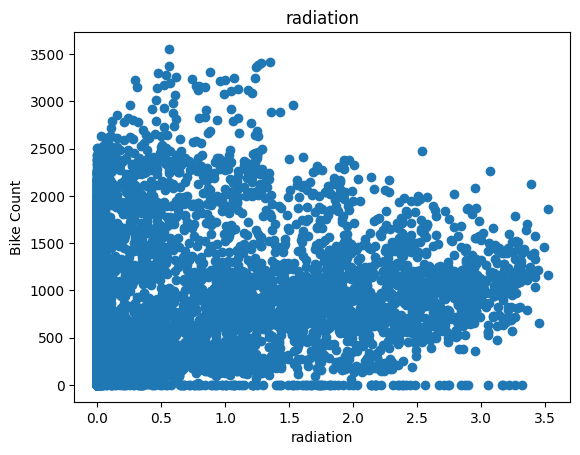

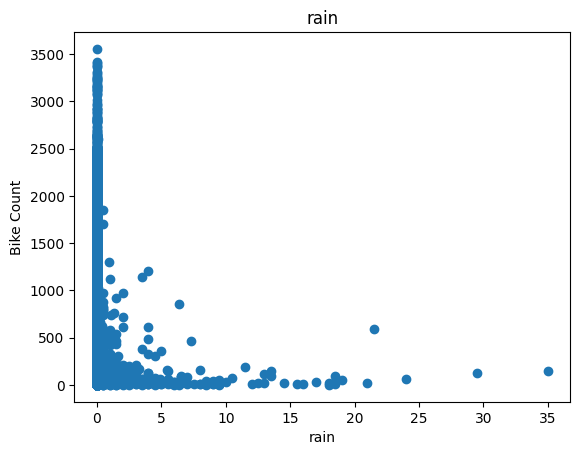

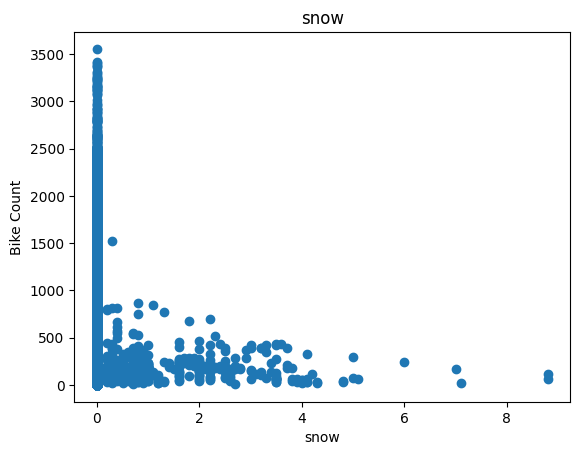

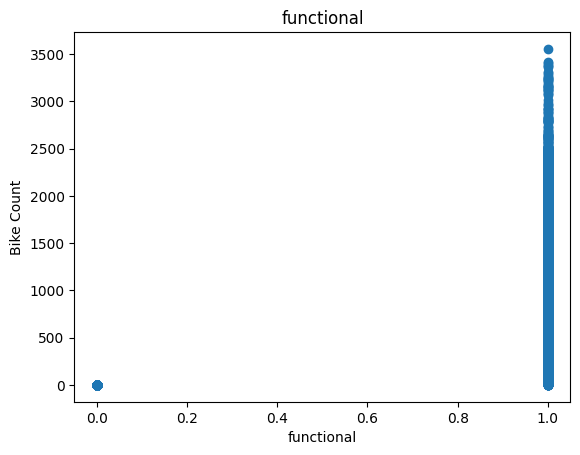

In [9]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel("Bike Count")
  plt.show()

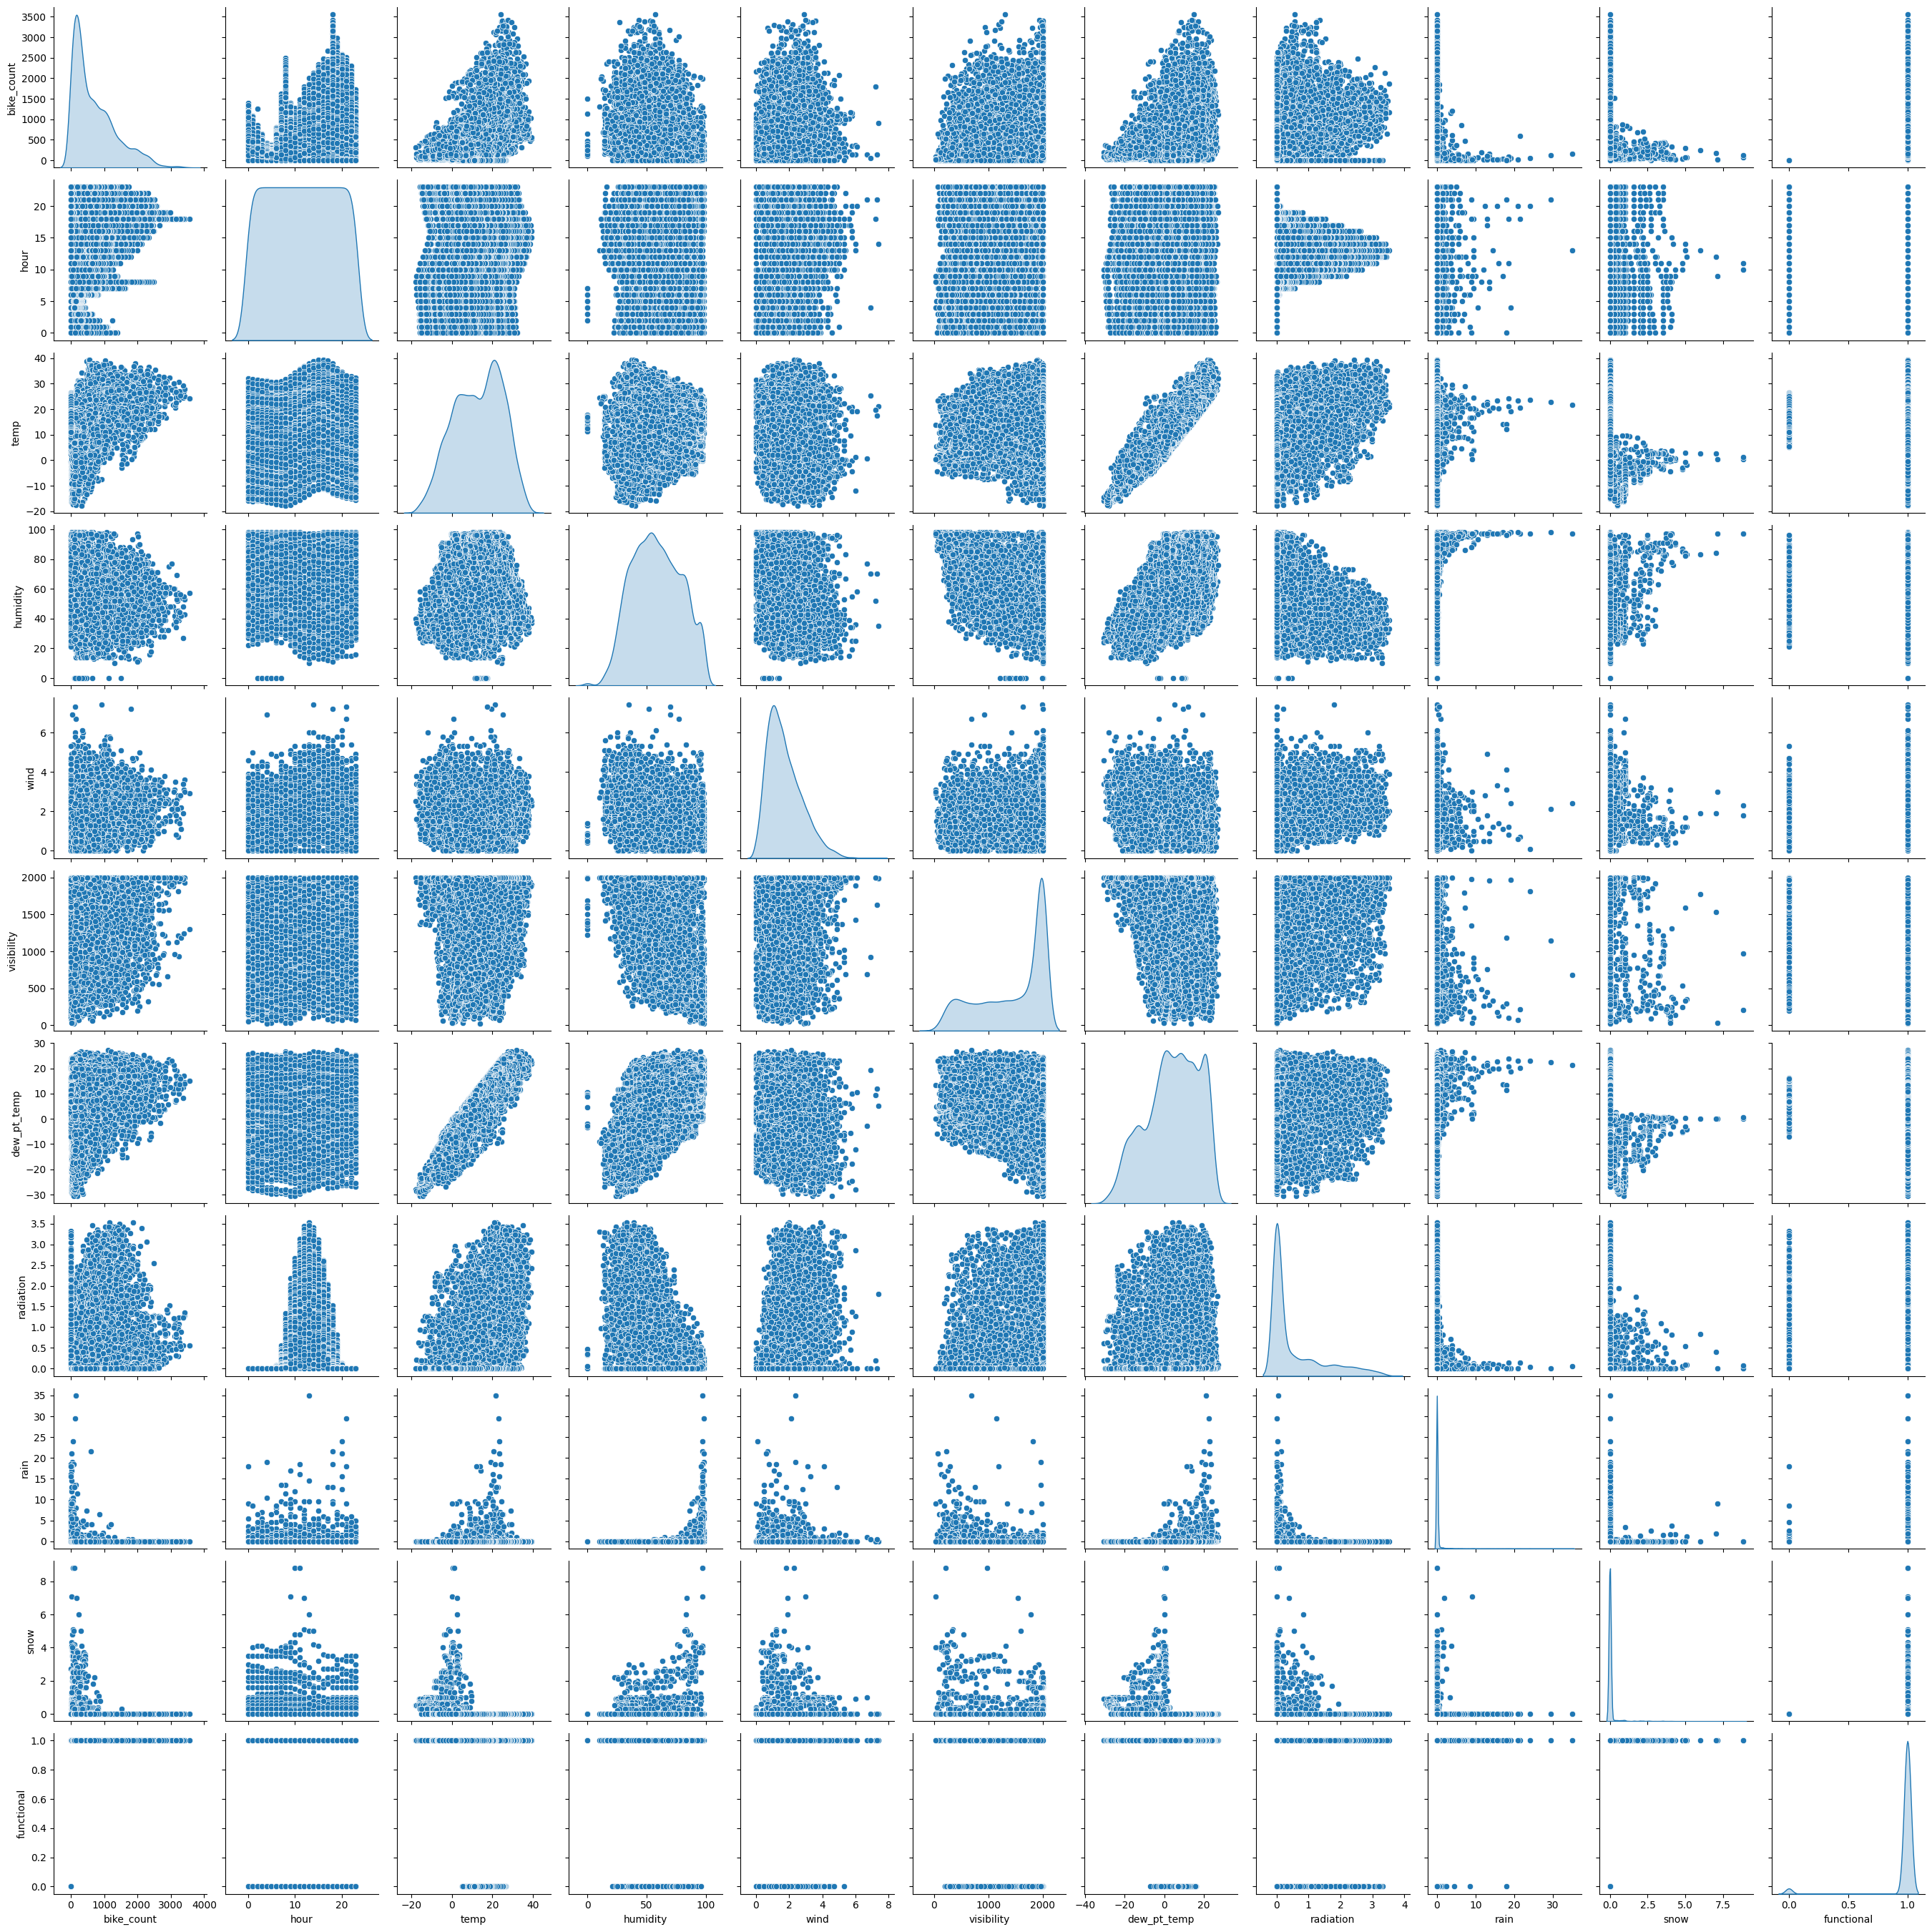

In [10]:
sns.pairplot(df, diag_kind = "kde")

In [11]:
df.corr()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
bike_count,1.000000,0.410257,0.538558,-0.199780,0.121108,0.199280,0.379788,0.261837,-0.123074,-0.141804,0.203943
hour,0.410257,1.000000,0.124114,-0.241644,0.285197,0.098753,0.003054,0.145131,0.008715,-0.021516,0.005439
temp,0.538558,0.124114,1.000000,0.159371,-0.036252,0.034794,0.912798,0.353505,0.050282,-0.218405,-0.050170
humidity,-0.199780,-0.241644,0.159371,1.000000,-0.336683,-0.543090,0.536894,-0.461919,0.236397,0.108183,-0.020800
wind,0.121108,0.285197,-0.036252,-0.336683,1.000000,0.171507,-0.176486,0.332274,-0.019674,-0.003554,0.005037
visibility,0.199280,0.098753,0.034794,-0.543090,0.171507,1.000000,-0.176630,0.149738,-0.167629,-0.121695,-0.026000
dew_pt_temp,0.379788,0.003054,0.912798,0.536894,-0.176486,-0.176630,1.000000,0.094381,0.125597,-0.150887,-0.052837
radiation,0.261837,0.145131,0.353505,-0.461919,0.332274,0.149738,0.094381,1.000000,-0.074290,-0.072301,-0.007665
rain,-0.123074,0.008715,0.050282,0.236397,-0.019674,-0.167629,0.125597,-0.074290,1.000000,0.008500,0.002055
snow,-0.141804,-0.021516,-0.218405,0.108183,-0.003554,-0.121695,-0.150887,-0.072301,0.008500,1.000000,0.032089


In [44]:
# Drop columns with no linearity with bike count
df = df.drop(["humidity", "wind", "visibility", "rain", "snow"], axis = 1)

In [45]:
df.head()

,bike_count,hour,temp,dew_pt_temp,radiation,functional
0,254,0,-5.2,-17.6,0.0,1
1,204,1,-5.5,-17.6,0.0,1
2,173,2,-6.0,-17.7,0.0,1
3,107,3,-6.2,-17.6,0.0,1
4,78,4,-6.0,-18.6,0.0,1


# Train, validation, and test dataset

In [46]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [47]:
def get_xy(dataframe, y_label, x_labels = None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      x = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((x, y))
  return data, x, y

In [48]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels = ["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels = ["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels = ["temp"])

#Simple Linear Regression

In [49]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [50]:
print(temp_reg.coef_, temp_reg.intercept_)

[[29.12470964]] [327.65254299]


In [51]:
temp_reg.score(x_test_temp, y_test_temp)

0.28058368144687174

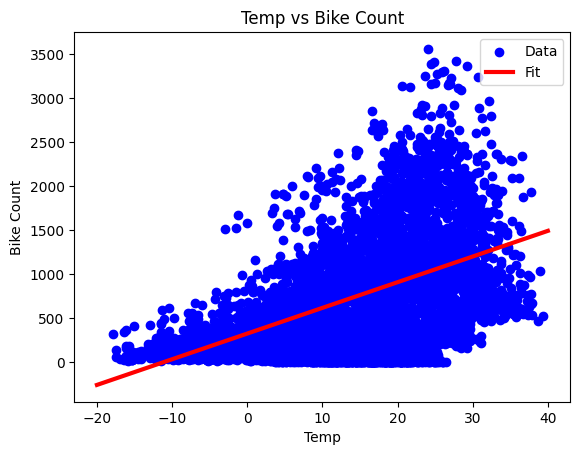

In [52]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Temp vs Bike Count")
plt.xlabel("Temp")
plt.ylabel("Bike Count")
plt.show()

#Multiple Linear Regression

In [53]:
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels = df.columns[1:])
_, x_val_all, y_val_all = get_xy(val, "bike_count", x_labels = df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels = df.columns[1:])

In [54]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [55]:
all_reg.score(x_test_all, y_test_all)

0.48534811971341296

In [23]:
y_pred_lr = all_reg.predict(x_test_all)

# Linear Regression with Neural Net

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [ ]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
temp_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = "mean_squared_error")

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs = 1000,
    validation_data = (x_val_temp, y_val_temp)
)

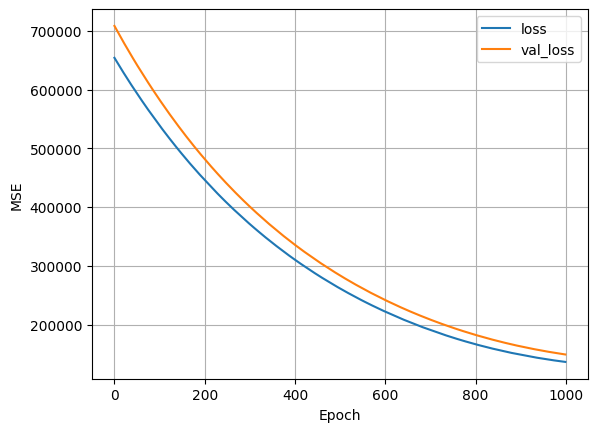

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


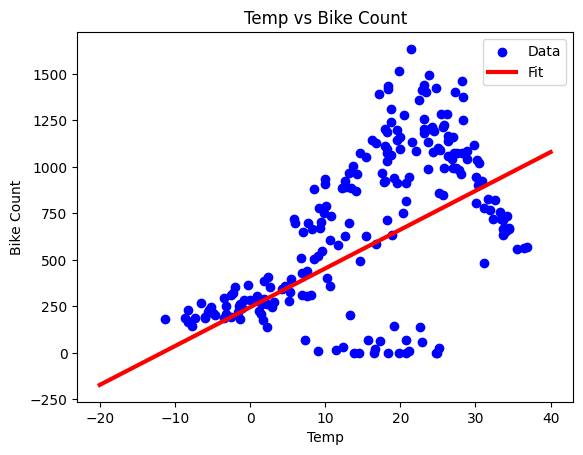

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Temp vs Bike Count")
plt.xlabel("Temp")
plt.ylabel("Bike Count")
plt.show()

#Neural Net

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mean_squared_error")

In [ ]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    verbose = 0,
    epochs = 100,
    validation_data = (x_val_temp, y_val_temp)
)

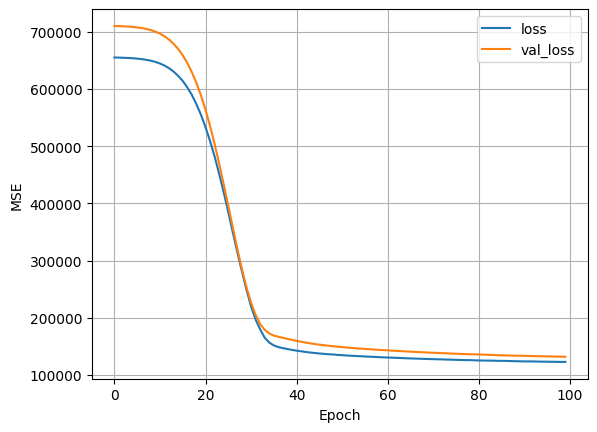

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


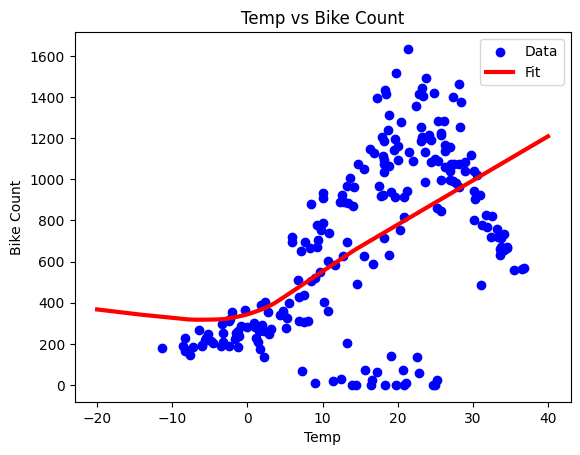

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Temp vs Bike Count")
plt.xlabel("Temp")
plt.ylabel("Bike Count")
plt.show()

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape = (6,), axis = -1)
all_normalizer.adapt(x_train_all)

In [ ]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mean_squared_error")

In [ ]:
history = nn_model.fit(
    x_train_all, y_train_all,
    verbose = 0,
    epochs = 100,
    validation_data = (x_val_all, y_val_all)
)

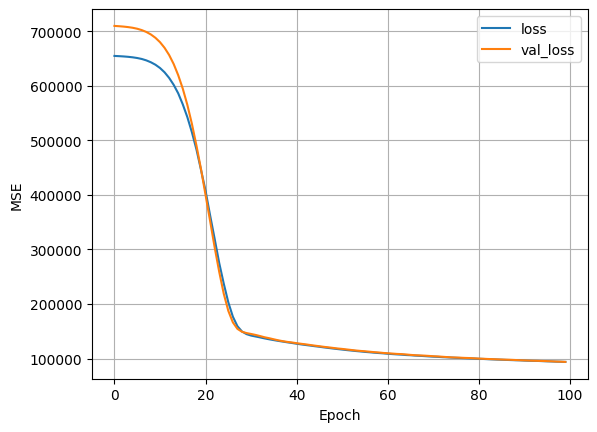

In [ ]:
plot_loss(history)

In [ ]:
# Calculate MSE for both linear reg and nn
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 [==============================] - 0s 6ms/step


In [ ]:
def MSE(y_pred, y_true):
  return (np.square(y_pred - y_true)).mean()

In [ ]:
MSE(y_pred_lr, y_test_all)

105114.15324062348

In [ ]:
MSE(y_pred_nn, y_test_all)

101207.78655781741

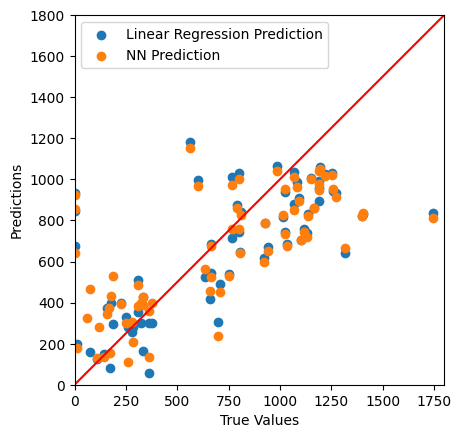

In [ ]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test_all, y_pred_lr, label = "Linear Regression Prediction")
plt.scatter(y_test_all, y_pred_nn, label = "NN Prediction")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c = "red")